# Model B: Kalman Filter for beta estimation in contex to CAPM
---

In [1]:
#importing all required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
# Plotly.express module can plot interactive plots easily and effectively.

In [2]:
import os

# Specify the new directory path
new_directory = "/Users/yadav/ERP/real-data-analysis/final-files"  # Replace with your desired path

# Change the current working directory
os.chdir(new_directory)

In [3]:
from sklearn.model_selection import train_test_split
# Load CSV file and parse the 'Date' column as dates
transformed_df = pd.read_csv("transformed_returns_(2015-2019).csv", parse_dates=['Date'], index_col='Date')

# Display the first few rows to check if the file was loaded correctly
print(transformed_df.head())

# Assuming you have your transformed DataFrame `transformed_df`
linear_train_df, linear_test_df = train_test_split(transformed_df, test_size=0.2, shuffle=False) #shuffle would be false as we are dealing with time series data


            Market_Returns  Asset_Returns
Date                                     
2015-01-02        0.000000       0.000000
2015-01-05       -0.018278      -0.016890
2015-01-06       -0.008894      -0.030320
2015-01-07        0.011629      -0.002606
2015-01-08        0.017888       0.037617


In [4]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Assuming transformed_df has been prepared as in previous steps
# Extract the necessary columns for the state-space model
observations = transformed_df[['Market_Returns', 'Asset_Returns']]

market_var = linear_train_df['Market_Returns'].var()
asset_var = linear_train_df['Asset_Returns'].var()

# Step 2: Define initial state parameters
initial_state_mean = [0, 1]  # Initial guess for alpha and beta
initial_state_covariance = np.array([[asset_var, 0], [0, market_var]])  # Initial covariance matrix

# Initialize observation noise covariance (can later be optimized via EM)
observation_covariance = np.eye(1) * asset_var

# Construct the observation matrix for the training data
observation_matrices = np.array([
    [1, linear_train_df['Market_Returns'].values[i]] for i in range(len(linear_train_df))
])

# Reshape observation_matrices to have the correct shape for pykalman
observation_matrices = observation_matrices.reshape(-1, 1, 2)

# Step 3: Estimate the observation covariance and process covariance using the EM algorithm
kf = KalmanFilter(
    transition_matrices=np.eye(2),
    observation_matrices=observation_matrices,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance = observation_covariance,
    em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance']
)

# Apply EM algorithm to training data
kf = kf.em(linear_train_df['Asset_Returns'].values, n_iter=100)

# Step 4: Filter the training set to estimate the states
state_means, state_covariances = kf.filter(linear_train_df['Asset_Returns'].values)

# Step 5: Use the filtered states to forecast on the test set
predicted_means = []
predicted_covariances = []

for t in range(len(linear_test_df)):
    observation_matrix_test = np.array([[1, linear_test_df['Market_Returns'].iloc[t]]])
    
    # Update the filter with the new observation
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean=state_means[-1], 
        filtered_state_covariance=state_covariances[-1],
        observation=linear_test_df['Asset_Returns'].iloc[t],
        observation_matrix=observation_matrix_test
    )
    
    predicted_means.append(filtered_state_mean)
    predicted_covariances.append(filtered_state_covariance)

predicted_means = np.array(predicted_means)
predicted_covariances = np.array(predicted_covariances)

# Step 6: Extract the estimated beta
train_estimated_beta = state_means[:, 1]
test_estimated_beta = predicted_means[:, 1]
test_estimated_alpha = predicted_means[:, 0]



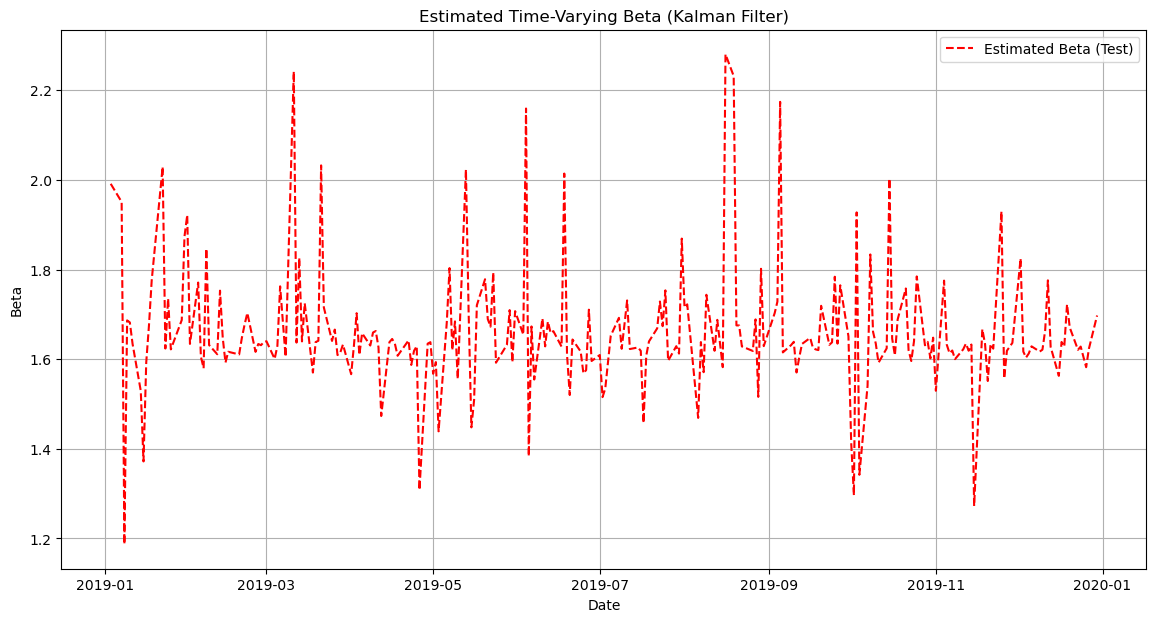

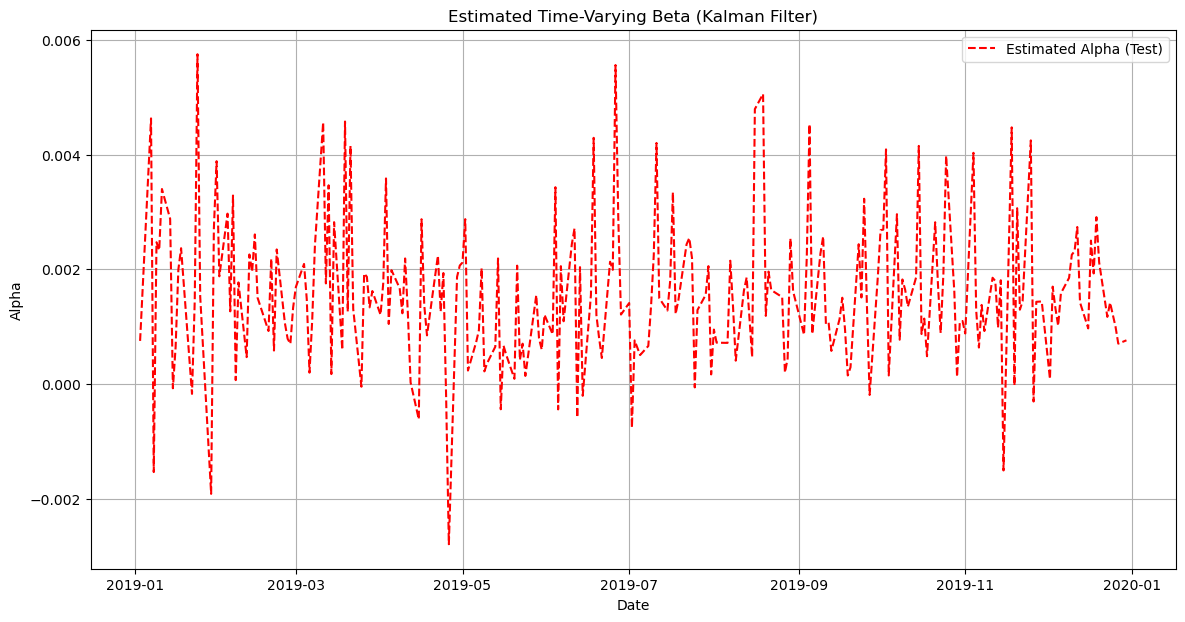

In [5]:
# Step 7: Plot the estimated beta over time
plt.figure(figsize=(14, 7))
plt.plot(linear_test_df.index, test_estimated_beta, label='Estimated Beta (Test)', color='red', linestyle='--')
plt.title('Estimated Time-Varying Beta (Kalman Filter)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Plot the estimated beta over time
plt.figure(figsize=(14, 7))
plt.plot(linear_test_df.index, test_estimated_alpha, label='Estimated Alpha (Test)', color='red', linestyle='--')
plt.title('Estimated Time-Varying Beta (Kalman Filter)')
plt.xlabel('Date')
plt.ylabel('Alpha')
plt.legend()
plt.grid(True)
plt.show()


Predicted Asset Returns - Test RMSE: 0.01488590679707857
Predicted Asset Returns - Test MAE: 0.011215714153207235
Predicted Asset Returns - Test MAPE: 1.4639190704448826
Predicted Asset Returns - Test R^2: 0.5848115671507508


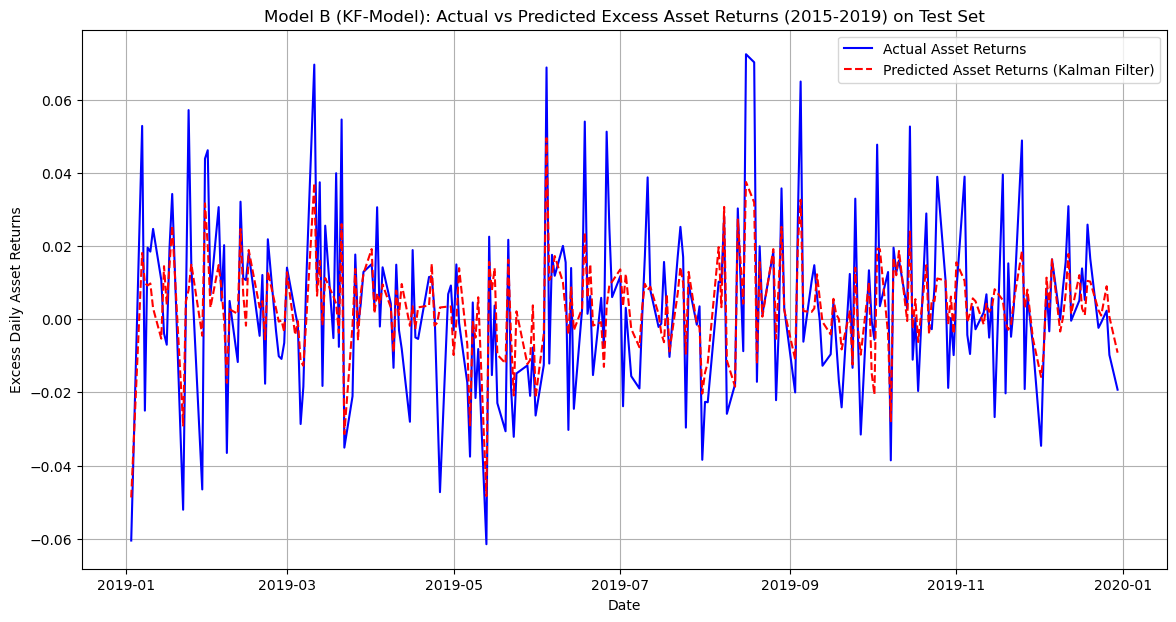

In [6]:

# Assuming we have the test_df and the predicted_means (state_means) from the Kalman Filter

# Step 1: Predict asset returns using the estimated betas
# Asset_Returns = alpha + beta * Market_Returns
predicted_asset_returns = np.array([pred[0] + pred[1] * linear_test_df['Market_Returns'].iloc[t] 
                                    for t, pred in enumerate(predicted_means)])

# Step 2: Calculate the evaluation metrics on the predicted asset returns
rmse_asset = np.sqrt(mean_squared_error(linear_test_df['Asset_Returns'], predicted_asset_returns))
mae_asset = mean_absolute_error(linear_test_df['Asset_Returns'], predicted_asset_returns)
mape_asset = mean_absolute_percentage_error(linear_test_df['Asset_Returns'], predicted_asset_returns)
r2_asset = r2_score(linear_test_df['Asset_Returns'], predicted_asset_returns)


print(f'Predicted Asset Returns - Test RMSE: {rmse_asset}')
print(f'Predicted Asset Returns - Test MAE: {mae_asset}')
print(f'Predicted Asset Returns - Test MAPE: {mape_asset}')
print(f'Predicted Asset Returns - Test R^2: {r2_asset}')

# Step 3: Plot the actual vs predicted asset returns for the test set
plt.figure(figsize=(14, 7))
plt.plot(linear_test_df.index, linear_test_df['Asset_Returns'], label='Actual Asset Returns', color='blue')
plt.plot(linear_test_df.index, predicted_asset_returns, label='Predicted Asset Returns (Kalman Filter)', color='red', linestyle='--')
plt.title('Model B (KF-Model): Actual vs Predicted Excess Asset Returns (2015-2019) on Test Set')
plt.xlabel('Date')
plt.ylabel('Excess Daily Asset Returns')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, save the predicted asset returns to a CSV for further analysis
predicted_asset_returns_df = pd.DataFrame({'Date': linear_test_df.index, 'Predicted_Asset_Returns': predicted_asset_returns})
predicted_asset_returns_df.to_csv('predicted_asset_returns_kalman.csv', index=True)


In [7]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

# Actual Asset Returns
fig.add_trace(go.Scatter(x=linear_test_df.index, 
                         y=linear_test_df['Asset_Returns'], 
                         mode='lines', 
                         name='Actual Asset Returns',
                         line=dict(color='blue')))

# Predicted Asset Returns
fig.add_trace(go.Scatter(x=linear_test_df.index, 
                         y=predicted_asset_returns, 
                         mode='lines', 
                         name='Predicted Asset Returns (Kalman Filter)',
                         line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(title='Actual vs Predicted Asset Returns (Kalman Filter)',
                  xaxis_title='Date',
                  yaxis_title='Asset Returns',
                  legend=dict(x=0, y=1.0),
                  hovermode='x unified')

# Show the figure
fig.show()
